In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import scipy
import scipy.integrate
import scipy.linalg
import scipy.fftpack
import math

import pychebfun as pcf

In [29]:
p_gen = np.polynomial.chebyshev.Chebyshev
p_basis = [p_gen.basis(deg=i)for i in range(100)]

def calc_mus(f, mu_k):
    mus = []
    for i in range(mu_k):
        p = p_basis[i]
        v,err,infodict = scipy.integrate.quad(
            lambda x: f(x)*p(x), -1, 1,
            epsrel=0.0,
            epsabs=1e-10,
            limit=200,
            full_output=True
        )
        mus.append(v)
    return np.array(mus)
def gen_pdf(lambd):
    cp = p_gen(lambd)
    def pdf(x):
        return np.exp(-cp(x))
    return pdf

In [1]:
def fit_cpoly(f, tol=1e-10):
    c_k = 32
    while True:
        xvals = np.cos(np.linspace(0,math.pi,c_k+1))
        fvals = f(xvals)
        cs = scipy.fftpack.dct(fvals, type=1) / c_k
        if abs(cs[-1]) < tol:
            break
        else:
            c_k *= 2
    cs[0] *= .5
    return cs

# Old version that doesn't using discrete cosine transform
def fit_cpoly_raw(f, tol=1e-10):
    c_k = 50
    while True:
        xvals = np.cos(np.linspace(0,math.pi,c_k+1))
        fvals = f(xvals)
        cs = np.zeros(c_k+1)
        for j in range(c_k+1):
            xjvals = np.cos(np.linspace(0,j*math.pi,c_k+1))
            cs[j] = (2.0/c_k)*(
                np.inner(fvals[1:-1],xjvals[1:-1]) 
                + .5*fvals[0]*xjvals[0]
                + .5*fvals[-1]*xjvals[-1]
            )
        # Last term of the expansion is an error bound
        if abs(cs[-1]) < tol:
            break
        else:
            c_k *= 2
    cs[0] *= .5
    return cs

In [31]:
def fplot(f):
    xs = np.linspace(-1,1,1000)
    ys = f(xs)
    plt.plot(xs, ys)

In [32]:
f = gen_pdf(np.array([1,2,3]))

In [33]:
calc_mus(f, 1)[0]

6.303954641290793

In [34]:
cf = pcf.chebfun(f, N=100)
cf.integrate()(1)

array(6.303954641290771)

In [35]:
v = scipy.integrate.romberg(
    f, -1, 1,
    rtol=0.0,
    tol=1e-10,
    vec_func=True,
#     show=True
)
print(v)

6.30395464129


In [36]:
cs = fit_cpoly(f, 1e-10)
fp = p_gen(cs)
print(fp.integ(lbnd=-1)(1))

6.30395464129


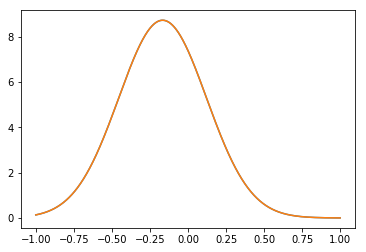

In [18]:
plt.figure()
xs = np.linspace(-1,1,1000)
y1s = f(xs)
y2s = fp(xs)
plt.plot(xs, y1s, label="orig")
plt.plot(xs, y2s, label="approx")

# Chebyshev Integrals

In [5]:
p_gen = np.polynomial.chebyshev.Chebyshev

In [9]:
cs = np.array([3, 1, 2])

In [30]:
def integ_cheby_coeffs(cs):
    k = len(cs)
    ics = np.zeros(k+1)
    ics[1] = cs[0]
    ics[2] = cs[1] / 4
    for i in range(2,k):
        ics[i+1] += cs[i]/(2*(i+1))
        ics[i-1] -= cs[i]/(2*(i-1))
    for i in range(1,k+1):
        ics[0] -= (-1)**i*ics[i]
    return ics

In [31]:
integ_cheby_coeffs(cs)

array([ 2.08333333,  2.        ,  0.25      ,  0.33333333])

In [32]:
cdf2 = p_gen(integ_cheby_coeffs(cs))

In [34]:
cdf2(1)

4.666666666666667

In [10]:
cdf = p_gen(cs).integ()
cdf(1) - cdf(-1)

4.666666666666667